## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.9, 0.5, 0.1]
redice_lr_patient = [5, 10, 15]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.90, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

50000/50000 [==============================] - 8s 151us/step - loss: 1.3178 - accuracy: 0.5423 - val_loss: 1.5034 - val_accuracy: 0.4758
Epoch 11/25
50000/50000 [==============================] - 7s 149us/step - loss: 1.2928 - accuracy: 0.5499 - val_loss: 1.4980 - val_accuracy: 0.4745
Epoch 12/25
50000/50000 [==============================] - 8s 150us/step - loss: 1.2651 - accuracy: 0.5614 - val_loss: 1.4772 - val_accuracy: 0.4772
Epoch 13/25
50000/50000 [==============================] - 8s 151us/step - loss: 1.2383 - accuracy: 0.5695 - val_loss: 1.4715 - val_accuracy: 0.4808
Epoch 14/25
50000/50000 [==============================] - 8s 151us/step - loss: 1.2140 - accuracy: 0.5793 - val_loss: 1.4736 - val_accuracy: 0.4822
Epoch 15/25
50000/50000 [==============================] - 8s 150us/step - loss: 1.1894 - accuracy: 0.5904 - val_loss: 1.4650 - val_accuracy: 0.4866
Epoch 16/25
50000/50000 [==============================] - 7s 149us/step - loss: 1.1673 - accuracy: 0.5970 - val_loss:

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 170us/step - loss: 2.1967 - accuracy: 0.2768 - val_loss: 2.1354 - val_accuracy: 0.2365
Epoch 2/25
50000/50000 [==============================] - 8s 156us/step - loss: 1.7431 - accuracy: 0.3954 - val_loss: 1.9786 - val_accuracy: 0.3069
Epoch 3/25
50000/50000 [==============================] - 8s 159us/step - loss: 1.6164 - accuracy: 0.4356 - val_loss: 1.8208 - val_accuracy: 0.3780
Epoch 4/25
50000/50000 [==============================] - 8s 151us/step - loss: 1.5418 - accuracy: 0.4619 - val_loss: 1.7149 - val_accuracy: 0.4176
Epoch 5/25
50000/50000 [==============================] - 8s 150us/step - loss: 1.4855 - accuracy: 0.4835 - val_loss: 1.6316 - val_accuracy: 0.4381
Epoch 6/25
50000/50000 [==============================] - 8s 150us/step - loss: 1.4421 - accuracy: 0.4977 - val_loss: 1.6056 - val_accuracy: 0.4419
Epoch 7/25
50000/50000 [==============================] - 7s 1

50000/50000 [==============================] - 8s 153us/step - loss: 1.0642 - accuracy: 0.6379 - val_loss: 1.4681 - val_accuracy: 0.4917
Epoch 21/25
50000/50000 [==============================] - 8s 156us/step - loss: 1.0397 - accuracy: 0.6476 - val_loss: 1.4519 - val_accuracy: 0.4988
Epoch 22/25
50000/50000 [==============================] - 8s 154us/step - loss: 1.0179 - accuracy: 0.6552 - val_loss: 1.4614 - val_accuracy: 0.4952
Epoch 23/25
50000/50000 [==============================] - 8s 153us/step - loss: 0.9958 - accuracy: 0.6627 - val_loss: 1.4610 - val_accuracy: 0.4963
Epoch 24/25
50000/50000 [==============================] - 8s 151us/step - loss: 0.9742 - accuracy: 0.6732 - val_loss: 1.4670 - val_accuracy: 0.4977
Epoch 25/25
50000/50000 [==============================] - 8s 151us/step - loss: 0.9542 - accuracy: 0.6800 - val_loss: 1.4847 - val_accuracy: 0.4887
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 15
Model: "model_6"
__________________________________________

Epoch 5/25
50000/50000 [==============================] - 8s 153us/step - loss: 1.4830 - accuracy: 0.4821 - val_loss: 1.6726 - val_accuracy: 0.4142
Epoch 6/25
50000/50000 [==============================] - 8s 154us/step - loss: 1.4365 - accuracy: 0.4982 - val_loss: 1.5896 - val_accuracy: 0.4468
Epoch 7/25
50000/50000 [==============================] - 8s 154us/step - loss: 1.3970 - accuracy: 0.5115 - val_loss: 1.5683 - val_accuracy: 0.4522
Epoch 8/25
50000/50000 [==============================] - 8s 155us/step - loss: 1.3607 - accuracy: 0.5264 - val_loss: 1.5223 - val_accuracy: 0.4605
Epoch 9/25
50000/50000 [==============================] - 8s 154us/step - loss: 1.3284 - accuracy: 0.5380 - val_loss: 1.5069 - val_accuracy: 0.4729
Epoch 10/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.2989 - accuracy: 0.5493 - val_loss: 1.4991 - val_accuracy: 0.4744
Epoch 11/25
50000/50000 [==============================] - 8s 154us/step - loss: 1.2699 - accuracy: 0.5604 - va

50000/50000 [==============================] - 8s 154us/step - loss: 1.5391 - accuracy: 0.4628 - val_loss: 1.6673 - val_accuracy: 0.4170
Epoch 25/25
50000/50000 [==============================] - 8s 154us/step - loss: 1.5298 - accuracy: 0.4658 - val_loss: 1.6621 - val_accuracy: 0.4168
Numbers of exp: 8, reduce_factor: 0.10, reduce_patient: 15
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_25 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
____________________________________________

Epoch 9/25
50000/50000 [==============================] - 8s 160us/step - loss: 1.0488 - accuracy: 0.6303 - val_loss: 2.0539 - val_accuracy: 0.3568

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.
Epoch 10/25
50000/50000 [==============================] - 8s 158us/step - loss: 0.9870 - accuracy: 0.6548 - val_loss: 1.6765 - val_accuracy: 0.4385
Epoch 11/25
50000/50000 [==============================] - 8s 165us/step - loss: 0.9507 - accuracy: 0.6669 - val_loss: 1.8978 - val_accuracy: 0.3831
Epoch 12/25
50000/50000 [==============================] - 8s 161us/step - loss: 0.9155 - accuracy: 0.6784 - val_loss: 1.8957 - val_accuracy: 0.3994
Epoch 13/25
50000/50000 [==============================] - 8s 159us/step - loss: 0.8767 - accuracy: 0.6922 - val_loss: 2.1015 - val_accuracy: 0.3990
Epoch 14/25
50000/50000 [==============================] - 8s 159us/step - loss: 0.8399 - accuracy: 0.7074 - val_loss: 1.7519 - val_accuracy: 0.4312

Epoch 00014: ReduceLROnPl

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 164us/step - loss: 1.7794 - accuracy: 0.3764 - val_loss: 2.5865 - val_accuracy: 0.2745
Epoch 2/25
50000/50000 [==============================] - 8s 163us/step - loss: 1.5332 - accuracy: 0.4558 - val_loss: 1.9620 - val_accuracy: 0.3530
Epoch 3/25
50000/50000 [==============================] - 8s 160us/step - loss: 1.4407 - accuracy: 0.4894 - val_loss: 1.6674 - val_accuracy: 0.4100
Epoch 4/25
50000/50000 [==============================] - 8s 158us/step - loss: 1.3792 - accuracy: 0.5112 - val_loss: 1.6306 - val_accuracy: 0.4058
Epoch 5/25
50000/50000 [==============================] - 8s 159us/step - loss: 1.3187 - accuracy: 0.5326 - val_loss: 1.7346 - val_accuracy: 0.3911
Epoch 6/25
50000/50000 [==============================] - 8s 160us/step - loss: 1.2650 - accuracy: 0.5525 - val_loss: 1.4821 - val_accuracy: 0.4687
Epoch 7/25
50000/50000 [==============================] - 8s 1

50000/50000 [==============================] - 8s 157us/step - loss: 0.7760 - accuracy: 0.7290 - val_loss: 1.6222 - val_accuracy: 0.4740
Epoch 21/25
50000/50000 [==============================] - 8s 159us/step - loss: 0.7565 - accuracy: 0.7356 - val_loss: 1.6602 - val_accuracy: 0.4701

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.00029524503042921424.
Epoch 22/25
50000/50000 [==============================] - 8s 161us/step - loss: 0.6581 - accuracy: 0.7782 - val_loss: 1.4851 - val_accuracy: 0.5191
Epoch 23/25
50000/50000 [==============================] - 8s 159us/step - loss: 0.6195 - accuracy: 0.7927 - val_loss: 1.5506 - val_accuracy: 0.5064
Epoch 24/25
50000/50000 [==============================] - 8s 158us/step - loss: 0.5962 - accuracy: 0.8025 - val_loss: 1.7038 - val_accuracy: 0.4916
Epoch 25/25
50000/50000 [==============================] - 8s 159us/step - loss: 0.5736 - accuracy: 0.8116 - val_loss: 1.5299 - val_accuracy: 0.5207
Numbers of exp: 13, reduce_factor: 0

50000/50000 [==============================] - 10s 196us/step - loss: 1.3940 - accuracy: 0.5128 - val_loss: 1.6396 - val_accuracy: 0.4150
Epoch 4/25
50000/50000 [==============================] - 8s 165us/step - loss: 1.3244 - accuracy: 0.5359 - val_loss: 1.5401 - val_accuracy: 0.4583
Epoch 5/25
50000/50000 [==============================] - 8s 162us/step - loss: 1.2623 - accuracy: 0.5599 - val_loss: 1.5497 - val_accuracy: 0.4460
Epoch 6/25
50000/50000 [==============================] - 9s 174us/step - loss: 1.2100 - accuracy: 0.5785 - val_loss: 1.5602 - val_accuracy: 0.4532
Epoch 7/25
50000/50000 [==============================] - 9s 190us/step - loss: 1.1602 - accuracy: 0.5983 - val_loss: 1.5256 - val_accuracy: 0.4550
Epoch 8/25
50000/50000 [==============================] - 9s 174us/step - loss: 1.1155 - accuracy: 0.6134 - val_loss: 1.5089 - val_accuracy: 0.4572
Epoch 9/25
50000/50000 [==============================] - 9s 177us/step - loss: 1.0741 - accuracy: 0.6312 - val_loss: 1.46

50000/50000 [==============================] - 8s 163us/step - loss: 0.7389 - accuracy: 0.7647 - val_loss: 1.3534 - val_accuracy: 0.5354
Epoch 23/25
50000/50000 [==============================] - 8s 166us/step - loss: 0.7376 - accuracy: 0.7652 - val_loss: 1.3533 - val_accuracy: 0.5356
Epoch 24/25
50000/50000 [==============================] - 8s 166us/step - loss: 0.7378 - accuracy: 0.7664 - val_loss: 1.3534 - val_accuracy: 0.5365
Epoch 25/25
50000/50000 [==============================] - 8s 161us/step - loss: 0.7369 - accuracy: 0.7660 - val_loss: 1.3539 - val_accuracy: 0.5367
Numbers of exp: 16, reduce_factor: 0.10, reduce_patient: 10
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
________

50000/50000 [==============================] - 8s 158us/step - loss: 1.9869 - accuracy: 0.3205 - val_loss: 1.9619 - val_accuracy: 0.3092
Epoch 7/25
50000/50000 [==============================] - 8s 158us/step - loss: 1.9577 - accuracy: 0.3290 - val_loss: 1.9355 - val_accuracy: 0.3216
Epoch 8/25
50000/50000 [==============================] - 8s 158us/step - loss: 1.9323 - accuracy: 0.3371 - val_loss: 1.9202 - val_accuracy: 0.3306
Epoch 9/25
50000/50000 [==============================] - 8s 159us/step - loss: 1.9109 - accuracy: 0.3438 - val_loss: 1.9096 - val_accuracy: 0.3365
Epoch 10/25
50000/50000 [==============================] - 8s 159us/step - loss: 1.8925 - accuracy: 0.3483 - val_loss: 1.9028 - val_accuracy: 0.3441
Epoch 11/25
50000/50000 [==============================] - 8s 163us/step - loss: 1.8751 - accuracy: 0.3523 - val_loss: 1.8990 - val_accuracy: 0.3482
Epoch 12/25
50000/50000 [==============================] - 8s 162us/step - loss: 1.8605 - accuracy: 0.3571 - val_loss: 1.

50000/50000 [==============================] - 8s 160us/step - loss: 0.5928 - accuracy: 0.7964 - val_loss: 1.9910 - val_accuracy: 0.4372
Numbers of exp: 19, reduce_factor: 0.90, reduce_patient: 10
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_58 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_59 (Batc (None, 256)               1024      
___________________________________________________________

50000/50000 [==============================] - 8s 161us/step - loss: 1.1101 - accuracy: 0.6120 - val_loss: 1.8424 - val_accuracy: 0.3880
Epoch 10/25
50000/50000 [==============================] - 8s 159us/step - loss: 1.0753 - accuracy: 0.6223 - val_loss: 2.1601 - val_accuracy: 0.3200
Epoch 11/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.0442 - accuracy: 0.6323 - val_loss: 2.0204 - val_accuracy: 0.3711
Epoch 12/25
50000/50000 [==============================] - 8s 163us/step - loss: 1.0111 - accuracy: 0.6453 - val_loss: 1.7292 - val_accuracy: 0.3977
Epoch 13/25
50000/50000 [==============================] - 8s 158us/step - loss: 0.9791 - accuracy: 0.6539 - val_loss: 1.8596 - val_accuracy: 0.3806
Epoch 14/25
50000/50000 [==============================] - 8s 154us/step - loss: 0.9466 - accuracy: 0.6701 - val_loss: 1.7038 - val_accuracy: 0.4369
Epoch 15/25
50000/50000 [==============================] - 8s 155us/step - loss: 0.9119 - accuracy: 0.6798 - val_loss:

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 162us/step - loss: 1.8591 - accuracy: 0.3624 - val_loss: 2.0868 - val_accuracy: 0.2470
Epoch 2/25
50000/50000 [==============================] - 8s 156us/step - loss: 1.5608 - accuracy: 0.4534 - val_loss: 1.9008 - val_accuracy: 0.3166
Epoch 3/25
50000/50000 [==============================] - 8s 154us/step - loss: 1.4499 - accuracy: 0.4938 - val_loss: 1.7682 - val_accuracy: 0.3780
Epoch 4/25
50000/50000 [==============================] - 8s 164us/step - loss: 1.3785 - accuracy: 0.5183 - val_loss: 1.6696 - val_accuracy: 0.4194
Epoch 5/25
50000/50000 [==============================] - 8s 164us/step - loss: 1.3175 - accuracy: 0.5393 - val_loss: 1.6369 - val_accuracy: 0.4242
Epoch 6/25
50000/50000 [==============================] - 8s 159us/step - loss: 1.2665 - accuracy: 0.5573 - val_loss: 1.6539 - val_accuracy: 0.4189
Epoch 7/25
50000/50000 [==============================] - 8s 1

50000/50000 [==============================] - 8s 155us/step - loss: 0.8081 - accuracy: 0.7297 - val_loss: 2.4048 - val_accuracy: 0.3554
Epoch 21/25
50000/50000 [==============================] - 8s 155us/step - loss: 0.7844 - accuracy: 0.7370 - val_loss: 1.7464 - val_accuracy: 0.4319
Epoch 22/25
50000/50000 [==============================] - 8s 158us/step - loss: 0.7597 - accuracy: 0.7453 - val_loss: 1.7227 - val_accuracy: 0.4517
Epoch 23/25
50000/50000 [==============================] - 8s 169us/step - loss: 0.7328 - accuracy: 0.7570 - val_loss: 1.7134 - val_accuracy: 0.4499
Epoch 24/25
50000/50000 [==============================] - 9s 172us/step - loss: 0.7106 - accuracy: 0.7651 - val_loss: 1.8387 - val_accuracy: 0.4419
Epoch 25/25
50000/50000 [==============================] - 9s 179us/step - loss: 0.6877 - accuracy: 0.7737 - val_loss: 1.9457 - val_accuracy: 0.4087
Numbers of exp: 24, reduce_factor: 0.10, reduce_patient: 5
Model: "model_25"
_________________________________________

Epoch 3/25
50000/50000 [==============================] - 8s 158us/step - loss: 2.9379 - accuracy: 0.1171 - val_loss: 2.4568 - val_accuracy: 0.1065
Epoch 4/25
50000/50000 [==============================] - 8s 154us/step - loss: 2.9140 - accuracy: 0.1196 - val_loss: 2.4930 - val_accuracy: 0.1111
Epoch 5/25
50000/50000 [==============================] - 8s 160us/step - loss: 2.8922 - accuracy: 0.1226 - val_loss: 2.5246 - val_accuracy: 0.1181
Epoch 6/25
50000/50000 [==============================] - 8s 156us/step - loss: 2.8703 - accuracy: 0.1247 - val_loss: 2.5544 - val_accuracy: 0.1245
Epoch 7/25
50000/50000 [==============================] - 8s 166us/step - loss: 2.8494 - accuracy: 0.1283 - val_loss: 2.5829 - val_accuracy: 0.1276
Epoch 8/25
50000/50000 [==============================] - 8s 157us/step - loss: 2.8288 - accuracy: 0.1328 - val_loss: 2.6086 - val_accuracy: 0.1345
Epoch 9/25
50000/50000 [==============================] - 8s 159us/step - loss: 2.8091 - accuracy: 0.1342 - val_

50000/50000 [==============================] - 8s 160us/step - loss: 3.1472 - accuracy: 0.0861 - val_loss: 3.1503 - val_accuracy: 0.0857
Epoch 22/25
50000/50000 [==============================] - 8s 160us/step - loss: 3.1464 - accuracy: 0.0862 - val_loss: 3.1512 - val_accuracy: 0.0858
Epoch 23/25
50000/50000 [==============================] - 8s 157us/step - loss: 3.1474 - accuracy: 0.0863 - val_loss: 3.1518 - val_accuracy: 0.0857
Epoch 24/25
50000/50000 [==============================] - 8s 164us/step - loss: 3.1474 - accuracy: 0.0871 - val_loss: 3.1519 - val_accuracy: 0.0857
Epoch 25/25
50000/50000 [==============================] - 8s 161us/step - loss: 3.1477 - accuracy: 0.0867 - val_loss: 3.1519 - val_accuracy: 0.0857


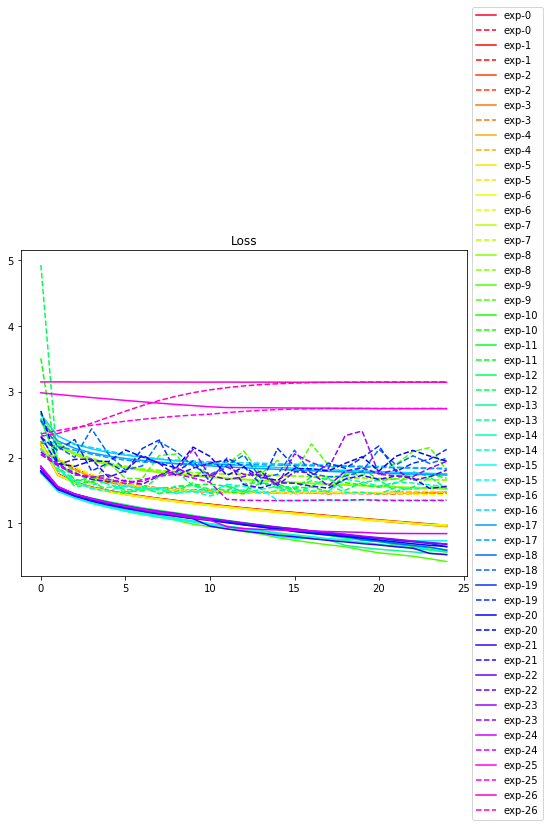

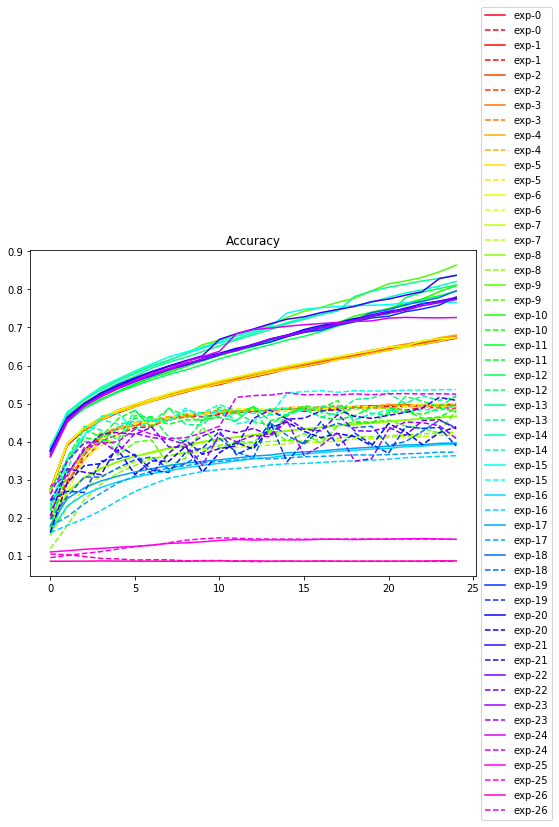

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()